<a href="https://colab.research.google.com/github/gamzeogutcu/Interstellar_Space_Travel/blob/main/interstellar_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Gerekli kütüphanelerin import işlemi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as mt
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore', category=FutureWarning)


# Features
#######################
### Age: Age of the traveler.
### Gender: Gender of the traveler.
### Occupation: Occupation of the traveler, such as Colonist, Tourist, Businessperson, etc.
### Travel Class: Class of travel, e.g., Business, Economy, Luxury.
### Destination: Interstellar destination.
### Star System: Star system of the destination.
### Distance to Destination (Light-Years): The distance to the destination measured in light-years.
### Duration of Stay (Earth Days): Duration of stay at the destination in Earth days.
### Number of Companions: The number of companions accompanying the traveler.
### Purpose of Travel: The primary purpose of travel, e.g., Tourism, Research, Colonization.
### Transportation Type: Type of transportation, e.g., Warp Drive, Solar Sailing, Ion Thruster.
### Price (Galactic Credits): Price of the trip in Galactic Credits.
### Booking Date: Date when the trip was booked.
### Departure Date: Date of departure.
### Special Requests: Any special requests made by the traveler.
### Loyalty Program Member: Indicates if the traveler is a member of a loyalty program.
### Month: Month of travel.


In [60]:
url = "https://raw.githubusercontent.com/Erayymsk/Interstellar_Space_Travel/main/datasets/interstellar_travel.csv"
df = pd.read_csv(url)
df = df.sample(n=50000, random_state=17)

In [61]:
# Genel Resim
def check_df(dataframe, head=5):
    print("##### Shape #####")
    print(dataframe.shape)
    print("##### Types #####")
    print(dataframe.dtypes)
    print("##### Head #####")
    print(dataframe.head())
    print("##### Tail #####")
    print(dataframe.tail())
    print("##### NA #####")
    print(dataframe.isnull().sum())
    print("##### Quantiles #####")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##### Duplicates #####")
    print(dataframe.duplicated().sum())
check_df(df)

##### Shape #####
(50000, 18)
##### Types #####
Age                                        int64
Gender                                    object
Occupation                                object
Travel Class                              object
Destination                               object
Star System                               object
Distance to Destination (Light-Years)    float64
Duration of Stay (Earth Days)            float64
Number of Companions                       int64
Purpose of Travel                         object
Transportation Type                       object
Price (Galactic Credits)                 float64
Booking Date                              object
Departure Date                            object
Special Requests                          object
Loyalty Program Member                    object
Month                                      int64
Customer Satisfaction Score              float64
dtype: object
##### Head #####
        Age  Gender      Occupation Tra

In [63]:
# Değişken isimlerini düzeltme
df = df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [64]:
# Tarih değişkenlerini datetime formatına getirme
df["BookingDate"] = pd.to_datetime(df["BookingDate"], format="%Y-%m-%d")
df["DepartureDate"] = pd.to_datetime(df["DepartureDate"], format="%Y-%m-%d")

In [65]:
# Price'ı 0'dan küçük olan satırlar var.
df[0 > df['PriceGalacticCredits']].count()
df=df[df['PriceGalacticCredits'] > 0]


In [66]:
# Kategorik ve numerik değişkenleri çekme
def grab_col_names(dataframe, cat_th=15, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car= grab_col_names(df)


Observations: 47290
Variables: 18
cat_cols: 10
num_cols: 7
cat_but_car: 1
num_but_cat: 2


        Gender      Ratio
Gender                   
Male     27542  58.240643
Female   19748  41.759357
##########################################


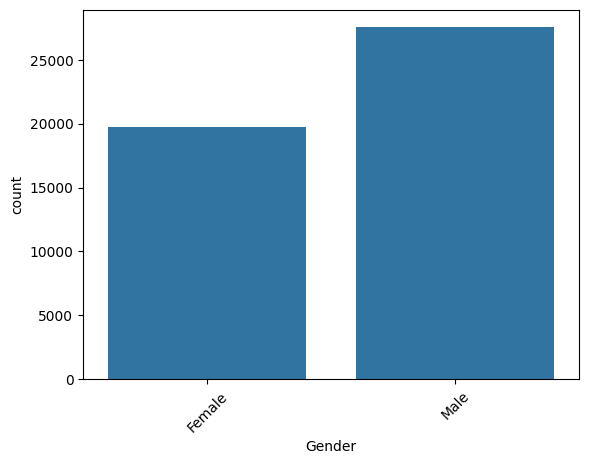

                Occupation      Ratio
Occupation                           
Tourist               8058  17.039543
Explorer              8034  16.988793
Businessperson        7918  16.743498
Colonist              7812  16.519349
Other                 7739  16.364982
Scientist             7729  16.343836
##########################################


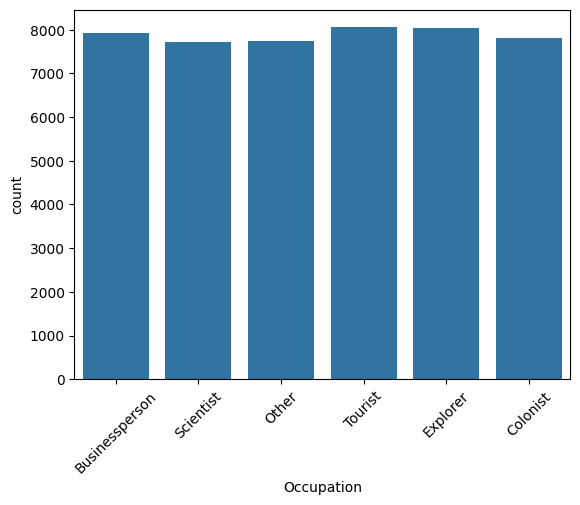

             TravelClass      Ratio
TravelClass                        
Economy            25948  54.869951
Business           15057  31.839712
Luxury              6285  13.290336
##########################################


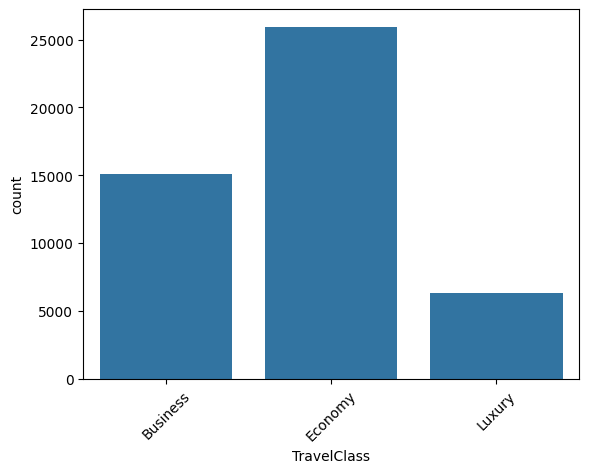

                       Destination     Ratio
Destination                                 
Proxima Centauri              4425  9.357158
Kepler-22b                    4405  9.314866
Barnard's Star                4343  9.183760
Gliese 581                    4285  9.061112
Zeta II Reticuli              4278  9.046310
Alpha Centauri                4273  9.035737
Tau Ceti                      4269  9.027278
Lalande 21185                 4240  8.965955
Epsilon Eridani               4218  8.919433
Trappist-1                    4217  8.917319
Exotic Destination 8           468  0.989638
Exotic Destination 5           468  0.989638
Exotic Destination 4           464  0.981180
Exotic Destination 3           438  0.926200
Exotic Destination 2           436  0.921971
Exotic Destination 10          422  0.892366
Exotic Destination 9           421  0.890252
Exotic Destination 7           417  0.881793
Exotic Destination 1           403  0.852189
Exotic Destination 6           400  0.845845
##########

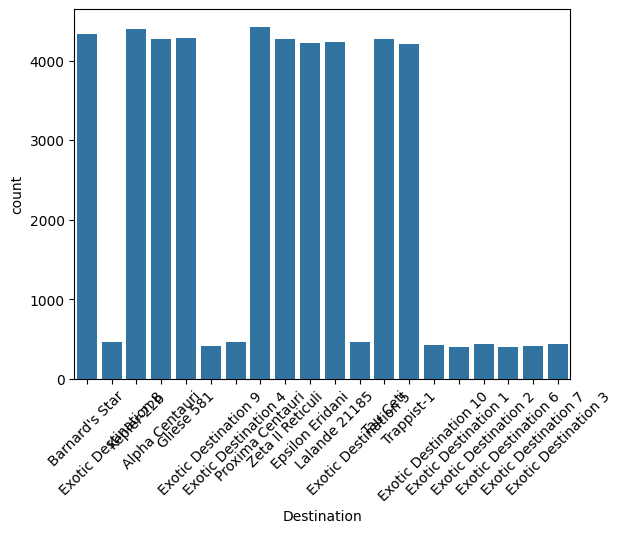

                 PurposeofTravel      Ratio
PurposeofTravel                            
Tourism                     9722  20.558258
Business                    9492  20.071897
Research                    9407  19.892155
Colonization                9362  19.796997
Other                       9307  19.680694
##########################################


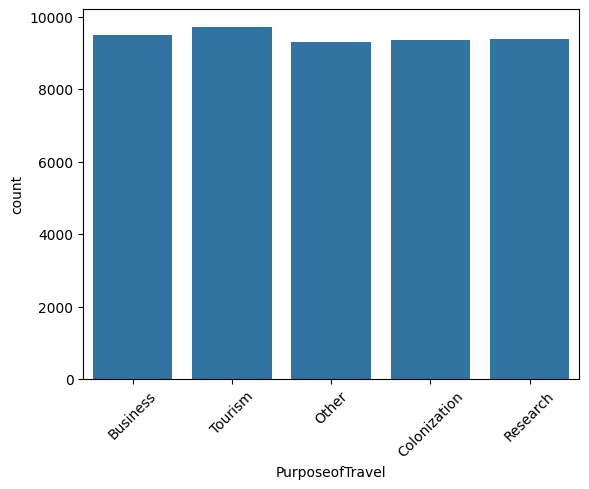

                    TransportationType      Ratio
TransportationType                               
Solar Sailing                    11925  25.216748
Other                            11863  25.085642
Warp Drive                       11772  24.893212
Ion Thruster                     11730  24.804398
##########################################


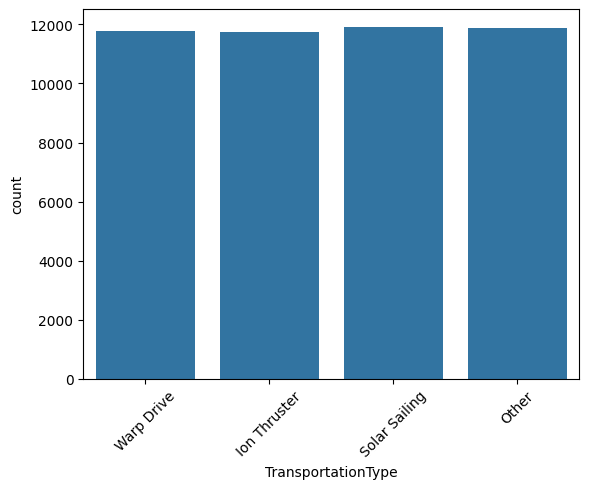

                  SpecialRequests      Ratio
SpecialRequests                             
Special Meal                 9501  20.090928
Window Seat                  9498  20.084584
Extra Space Suit             9465  20.014802
Other                        9381  19.837175
##########################################


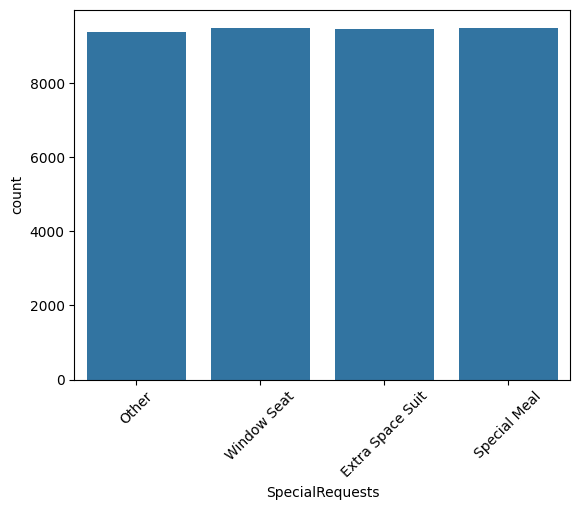

                      LoyaltyProgramMember      Ratio
LoyaltyProgramMember                                 
Yes                                  24656  52.137873
No                                   22634  47.862127
##########################################


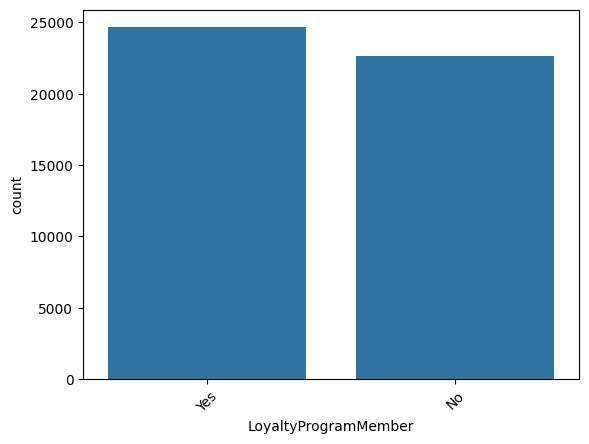

                    NumberofCompanions      Ratio
NumberofCompanions                               
1                                16853  35.637556
0                                16145  34.140410
2                                 9189  19.431169
3                                 3611   7.635864
4                                 1097   2.319729
5                                  283   0.598435
6                                   86   0.181857
7                                   22   0.046521
8                                    4   0.008458
##########################################


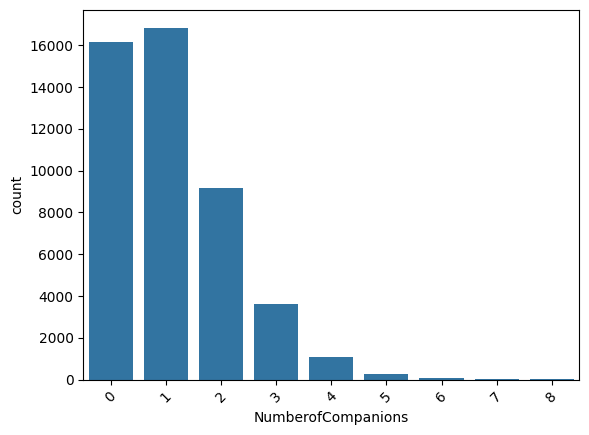

       Month     Ratio
Month                 
12      4303  9.099175
10      4289  9.069571
1       4193  8.866568
11      4149  8.773525
8       4125  8.722774
9       4039  8.540918
7       4023  8.507084
5       3784  8.001692
3       3760  7.950941
6       3659  7.737365
4       3645  7.707761
2       3321  7.022626
##########################################


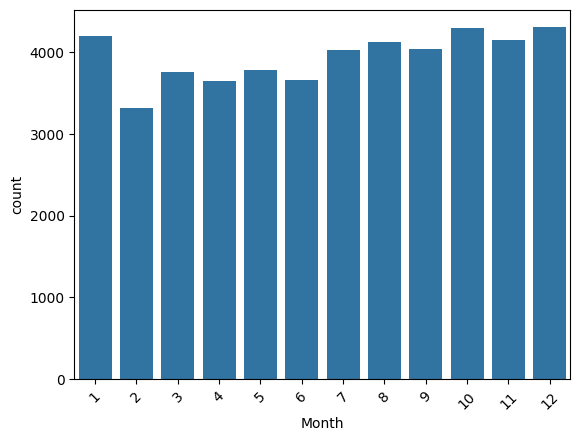

In [67]:
# Numerik ve kategorik değişkenlerin analizini yapınız.

# Kategorik değişkenler için
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation=45)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df,col,True)

count    47290.000000
mean        31.049588
std         19.624394
min          0.000000
5%           5.000000
10%          8.000000
20%         13.000000
30%         18.000000
40%         23.000000
50%         27.000000
60%         33.000000
70%         39.000000
80%         48.000000
90%         60.000000
95%         70.000000
99%         83.000000
max         98.000000
Name: Age, dtype: float64


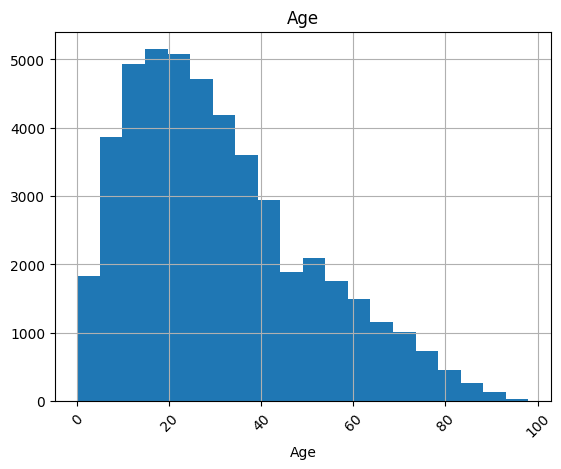

count    47290.000000
mean         8.481061
std         25.146053
min          0.010000
5%           0.230000
10%          0.390000
20%          0.770000
30%          1.240000
40%          1.860000
50%          2.710000
60%          3.980000
70%          5.970000
80%          9.650000
90%         18.681000
95%         31.655500
99%         91.569900
max       1549.980000
Name: DistancetoDestinationLightYears, dtype: float64


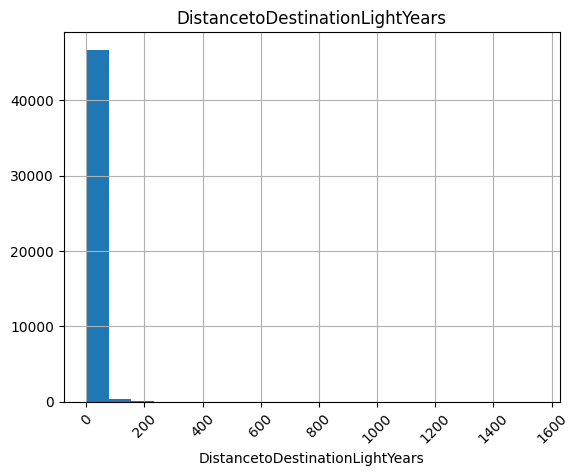

count    47290.000000
mean        33.646627
std         33.201797
min          0.000000
5%           3.000000
10%          5.000000
20%          9.000000
30%         12.000000
40%         16.500000
50%         22.000000
60%         29.000000
70%         40.000000
80%         55.000000
90%         80.000000
95%        102.000000
99%        150.000000
max        393.000000
Name: DurationofStayEarthDays, dtype: float64


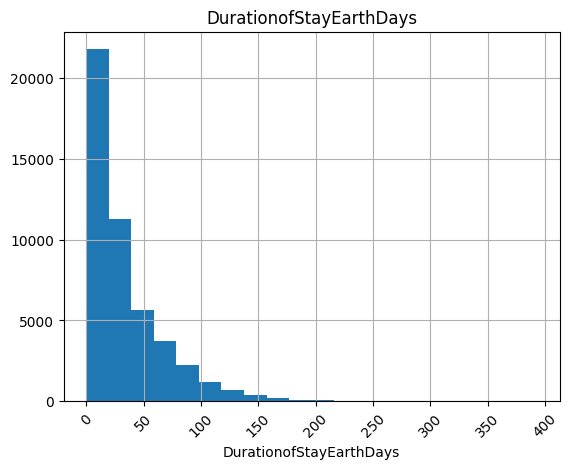

count    47290.000000
mean      1113.123043
std       1415.687756
min          0.188100
5%          82.577672
10%        145.082066
20%        261.781674
30%        389.112293
40%        526.536965
50%        689.283210
60%        898.392782
70%       1182.740328
80%       1611.517446
90%       2465.962711
95%       3499.844463
99%       6717.059284
max      35071.825800
Name: PriceGalacticCredits, dtype: float64


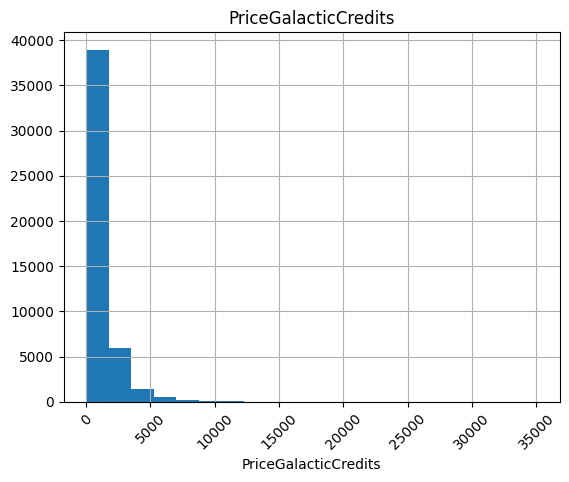

count    47290.000000
mean       103.405422
std          5.551716
min         71.760000
5%          93.000000
10%         97.000000
20%        100.000000
30%        102.000000
40%        102.000000
50%        103.000000
60%        105.000000
70%        107.000000
80%        107.000000
90%        110.000000
95%        112.000000
99%        115.000000
max        115.000000
Name: CustomerSatisfactionScore, dtype: float64


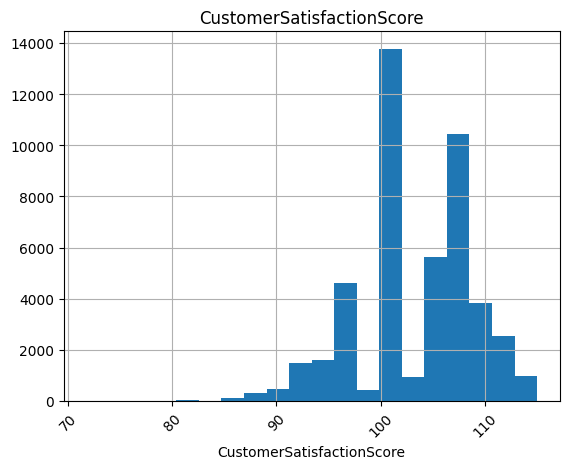

In [68]:
# Numerik değişkenler için
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.xticks(rotation=45)
        plt.show(block=True)


for col in num_cols:
  if col not in ["BookingDate","DepartureDate"]:
    num_summary(df,col,plot=True)

        TARGET_MEAN
Gender             
Female   103.843014
Male     103.091661


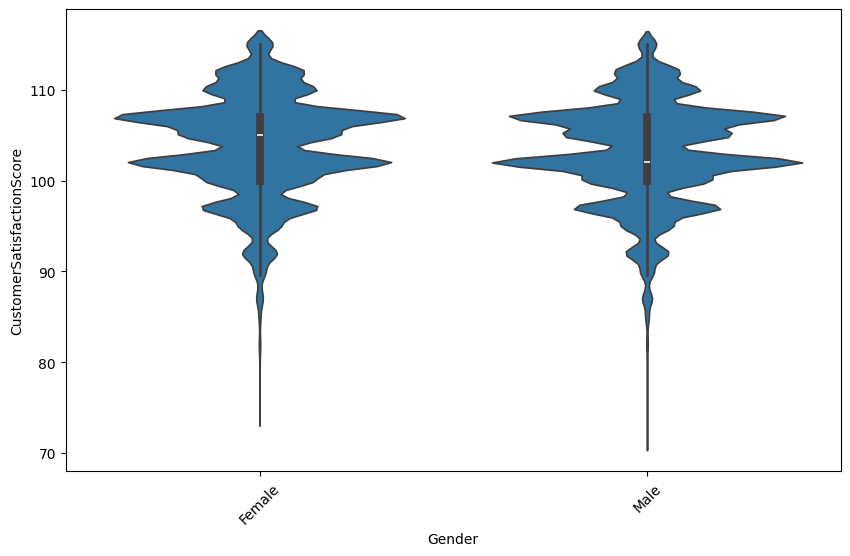

                TARGET_MEAN
Occupation                 
Businessperson   101.660918
Colonist         104.406422
Explorer         104.119010
Other            104.244083
Scientist        101.451554
Tourist          104.506344


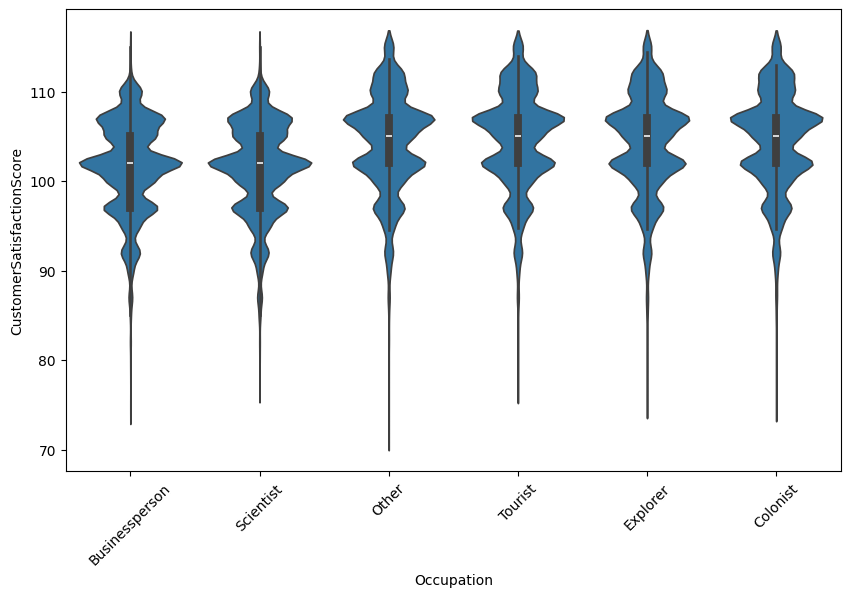

             TARGET_MEAN
TravelClass             
Business      103.184989
Economy       103.456814
Luxury        103.721338


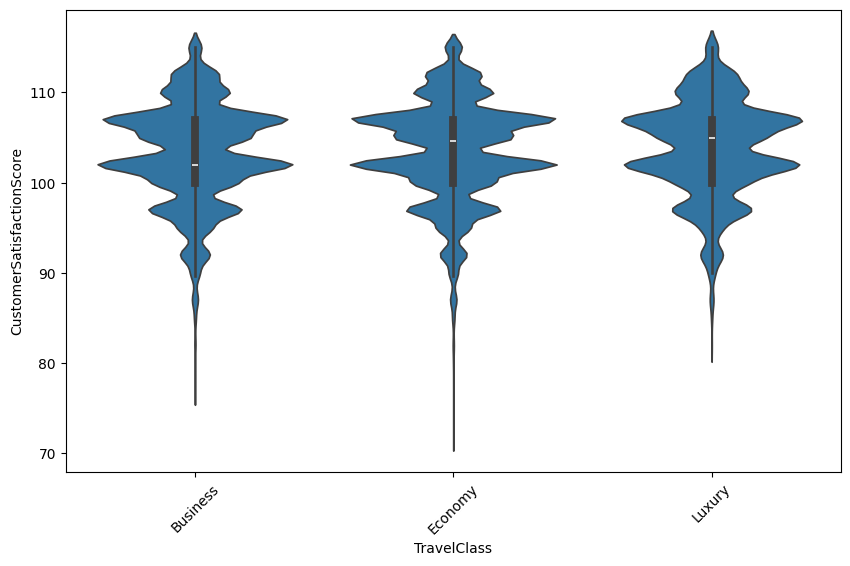

                       TARGET_MEAN
Destination                       
Alpha Centauri           99.196911
Barnard's Star          104.246323
Epsilon Eridani         104.330289
Exotic Destination 1    104.435136
Exotic Destination 10   104.628318
Exotic Destination 2    104.118601
Exotic Destination 3    104.319315
Exotic Destination 4    104.268470
Exotic Destination 5    104.197585
Exotic Destination 6    104.383375
Exotic Destination 7    104.210767
Exotic Destination 8    104.547607
Exotic Destination 9    104.392328
Gliese 581              104.235736
Kepler-22b              104.318888
Lalande 21185           104.365314
Proxima Centauri        104.437444
Tau Ceti                104.286866
Trappist-1               99.237446
Zeta II Reticuli        104.325117


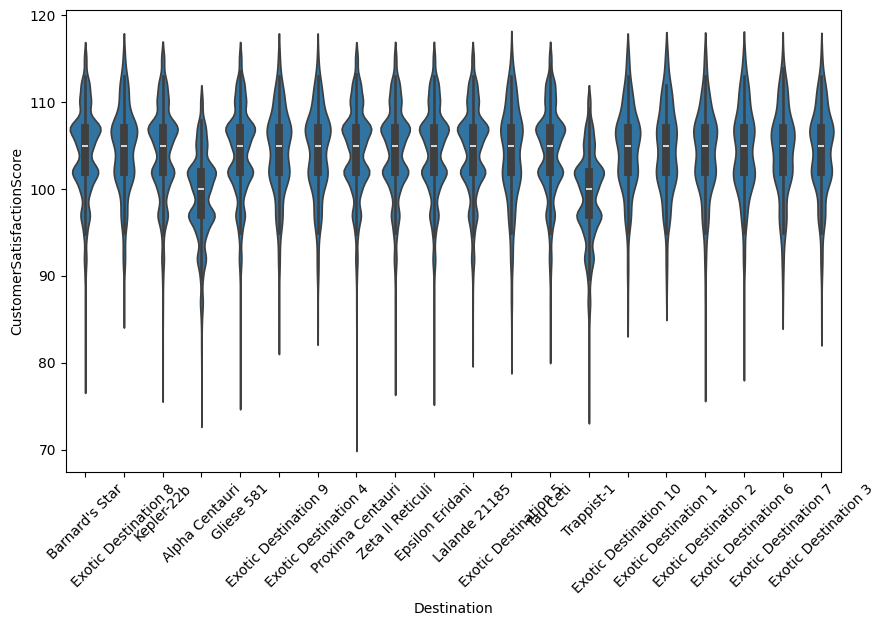

                 TARGET_MEAN
PurposeofTravel             
Business          103.456519
Colonization      103.488250
Other             103.429036
Research          103.480934
Tourism           103.180099


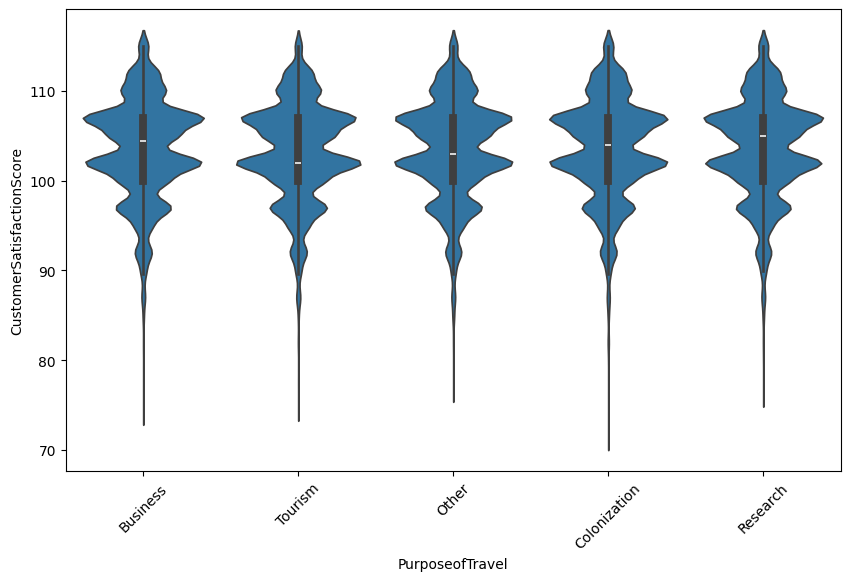

                    TARGET_MEAN
TransportationType             
Ion Thruster         102.684439
Other                102.633856
Solar Sailing        102.660583
Warp Drive           105.655882


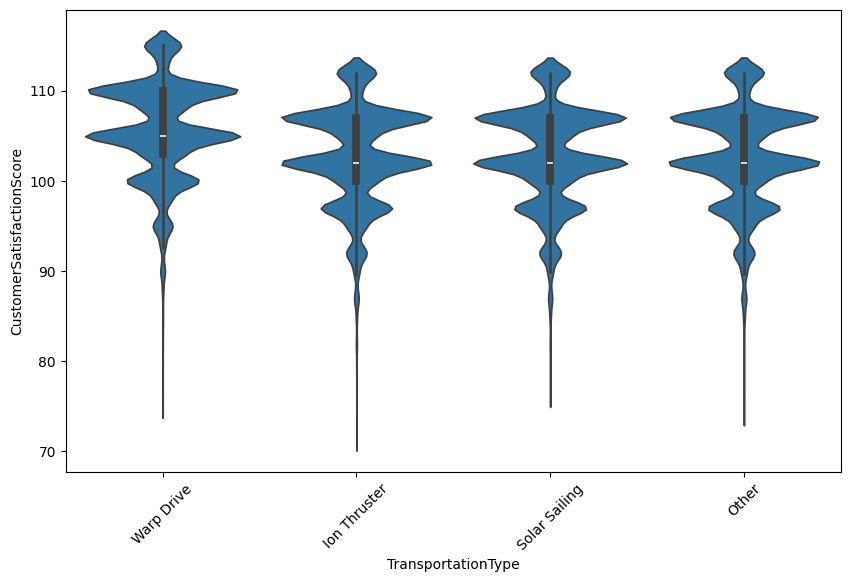

                  TARGET_MEAN
SpecialRequests              
Extra Space Suit   103.835681
Other              103.738828
Special Meal       103.850907
Window Seat        103.767981


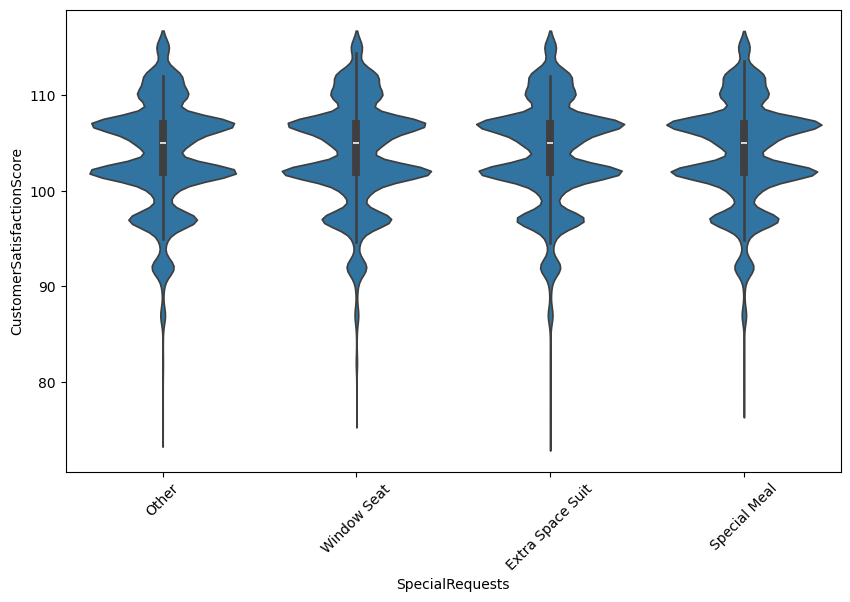

                      TARGET_MEAN
LoyaltyProgramMember             
No                     101.455338
Yes                    105.195582


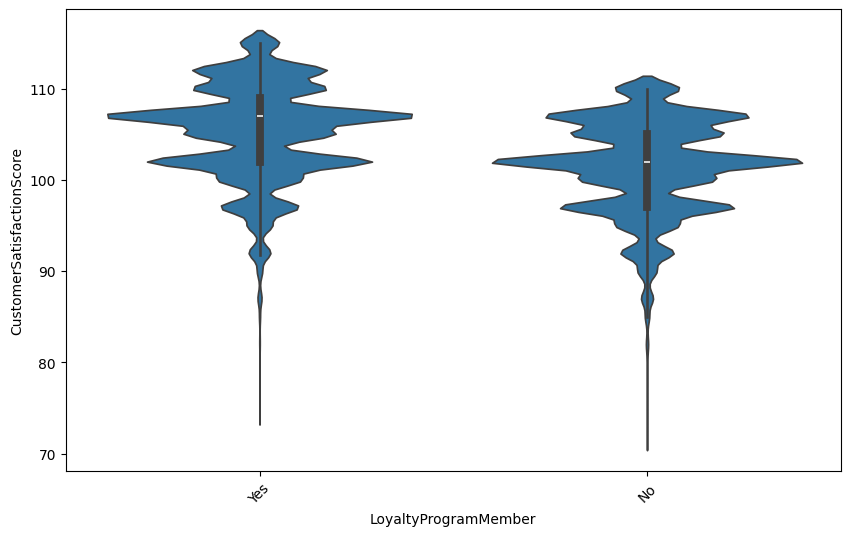

                    TARGET_MEAN
NumberofCompanions             
0                    103.380465
1                    103.466749
2                    103.659905
3                    103.834212
4                    100.395889
5                    100.446996
6                     99.670581
7                    101.090909
8                    101.750000


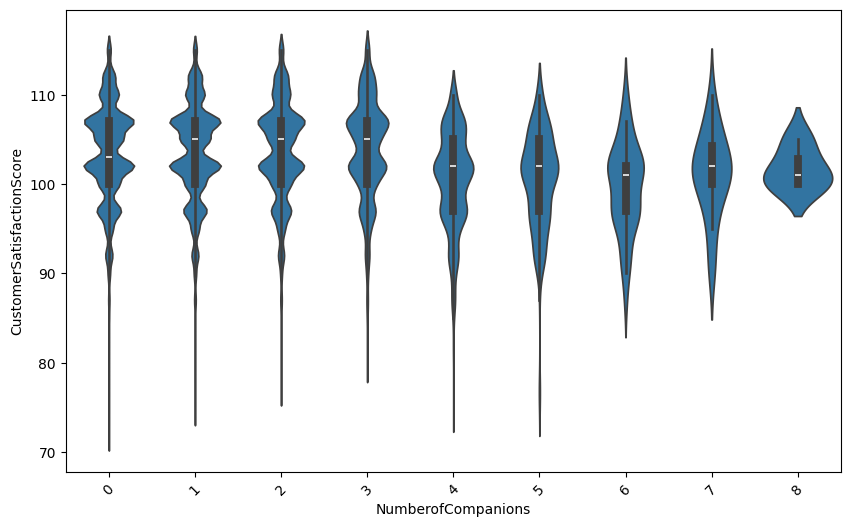

       TARGET_MEAN
Month             
1       104.540272
2       104.795113
3       104.759074
4       104.731663
5       104.616105
6        99.790063
7        99.690768
8        99.610589
9       104.742649
10      104.517246
11      104.493620
12      104.628527


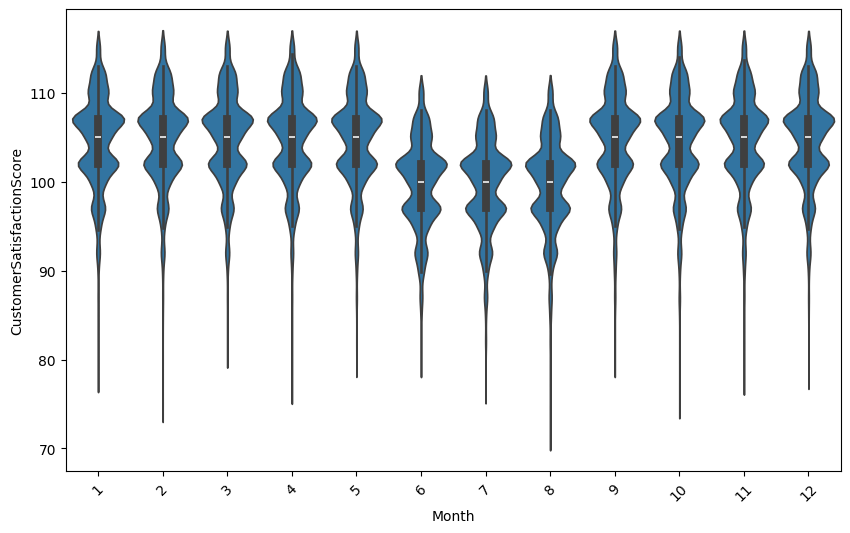

In [69]:
# Adım 4: Hedef değişken analizi yapınız.
def target_summary_with_cat(dataframe,target,categorical_col, plot=False):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))
    if plot:
        plt.figure(figsize=(10,6))
        sns.violinplot(data=dataframe, x=categorical_col,y=target)
        plt.xticks(rotation=45)
        plt.show(block=True)

for col in cat_cols:
    target_summary_with_cat(df,"CustomerSatisfactionScore", col, plot=True)

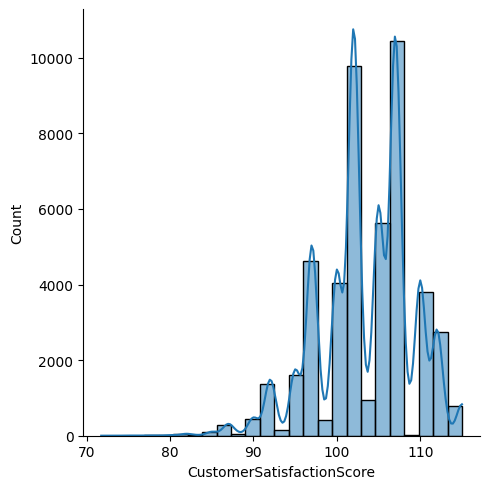

In [70]:
# Bağımlı değişkenin incelenmesi
sns.displot(df["CustomerSatisfactionScore"],kde=True,bins=25)
plt.show()

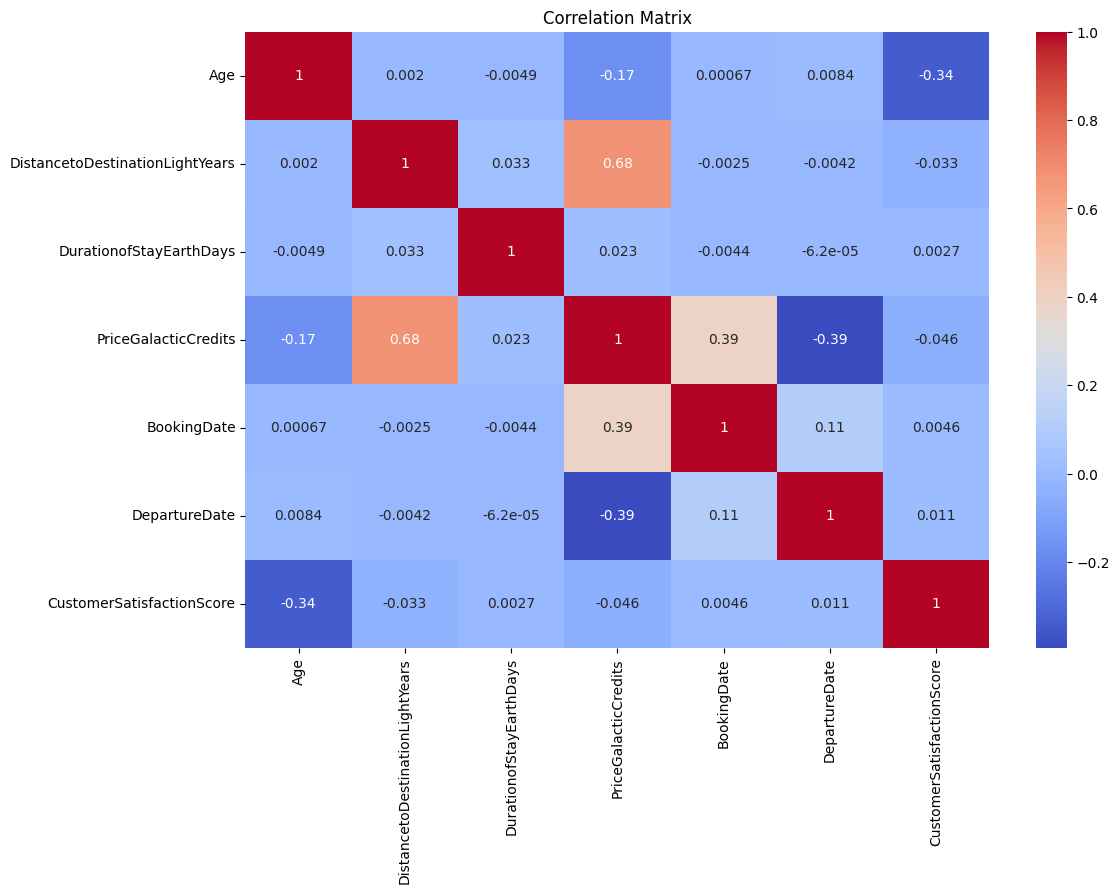

In [71]:
#Korelasyon analizi yapınız
corr = df[num_cols].corr(method="spearman")
# Korelasyon matrisi
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [72]:
# Aykırı (Outlier) değerler için gerekli işlemler
# Aykırı değer olup olmadığını kontrol etme
def outlier_thresholds(dataframe, col_name, q1=0.1, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    if col != "CustomerSatisfactionScore":
        print(col, check_outlier(df, col))


Age False
DistancetoDestinationLightYears True
DurationofStayEarthDays True
PriceGalacticCredits True
BookingDate False
DepartureDate False


In [73]:
# Aykırı değerleri baskılama
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    if col != "CustomerSatisfactionScore":
        replace_with_thresholds(df, col)

In [74]:
for col in num_cols:
    if col != "CustomerSatisfactionScore":
        print(col, check_outlier(df, col)) # Tekrar kontrol edelim

Age False
DistancetoDestinationLightYears False
DurationofStayEarthDays False
PriceGalacticCredits False
BookingDate False
DepartureDate False


In [75]:
# Eksik değer problemini çözme
df.isnull().sum()


Age                                   0
Gender                                0
Occupation                            0
TravelClass                           0
Destination                           0
StarSystem                            0
DistancetoDestinationLightYears       0
DurationofStayEarthDays               0
NumberofCompanions                    0
PurposeofTravel                       0
TransportationType                    0
PriceGalacticCredits                  0
BookingDate                           0
DepartureDate                         0
SpecialRequests                    9445
LoyaltyProgramMember                  0
Month                                 0
CustomerSatisfactionScore             0
dtype: int64

In [76]:
# Eksik verileri doldurma
df["SpecialRequests"].fillna("None",inplace=True)

In [77]:
# Yeni Değişkenler Oluşturma
# Kaldığı gece üzerinden olan verileri kaldığı gün olarak değiştirme işlemi.
df["DurationofStayEarthDays"] = df["DurationofStayEarthDays"].apply(lambda x: x + 1)

In [78]:
# Rezarvasyondan kalkışa kadar olan süre
df["Total_days_booking_to_departure"] = df["DepartureDate"]- df["BookingDate"]
df["Total_days_booking_to_departure"] = df["Total_days_booking_to_departure"].dt.days

In [79]:
# Çeşitli metriklerde ortalama ücreti hesaplama
df["cost_price_to_distance"] = df["PriceGalacticCredits"] / df["DistancetoDestinationLightYears"].replace(0,0.01)
df["Cost_price_to_stay"] = df["PriceGalacticCredits"] / df["DurationofStayEarthDays"]
df["Cost_price_to_companions"] = df["PriceGalacticCredits"] / df["NumberofCompanions"].replace(0,1)

In [80]:
# Yıl değişkenleri oluşturma
df["DepartureYear"] = df["DepartureDate"].dt.year
df["BookingYear"] = df["BookingDate"].dt.year

In [81]:
# Yaş kategorileri oluşturma
df.loc[(df['Age'] < 15), 'NEW_AGE_CAT'] = "children"
df.loc[(df['Age'] >= 15) & (df['Age'] < 25), 'NEW_AGE_CAT'] = "young"
df.loc[(df['Age'] >= 25) & (df['Age'] < 40), 'NEW_AGE_CAT'] = "mature"
df.loc[(df['Age'] >= 40) & (df['Age'] < 65), 'NEW_AGE_CAT'] = "middle_age"
df.loc[(df['Age'] >= 65) , 'NEW_AGE_CAT'] = "senior"

In [82]:
# Age x Gender
df.loc[(df['NEW_AGE_CAT'] == "children") & (df['Gender'] == "Male"), 'NEW_AGE_GENDER'] = "children_male"
df.loc[(df['NEW_AGE_CAT'] == "children") & (df['Gender'] == "Female"), 'NEW_AGE_GENDER'] = "children_female"

df.loc[(df['NEW_AGE_CAT'] == "young") & (df['Gender'] == "Male"), 'NEW_AGE_GENDER'] = "young_male"
df.loc[(df['NEW_AGE_CAT'] == "young") & (df['Gender'] == "Female"), 'NEW_AGE_GENDER'] = "young_female"

df.loc[(df['NEW_AGE_CAT'] == "mature") & (df['Gender'] == "Male"), 'NEW_AGE_GENDER'] = "mature_male"
df.loc[(df['NEW_AGE_CAT'] == "mature") & (df['Gender'] == "Female"), 'NEW_AGE_GENDER'] = "mature_female"

df.loc[(df['NEW_AGE_CAT'] == "middle_age") &
       (df['Gender'] == "Male"), 'NEW_AGE_GENDER'] = "middle_age_male"
df.loc[(df['NEW_AGE_CAT'] == "middle_age") &
       (df['Gender'] == "Female"), 'NEW_AGE_GENDER'] = "middle_age_female"

df.loc[(df['NEW_AGE_CAT'] == "senior") &
       (df['Gender'] == "Male"), 'NEW_AGE_GENDER'] = "senior_male"
df.loc[(df['NEW_AGE_CAT'] == "senior") &
       (df['Gender'] == "Female"), 'NEW_AGE_GENDER'] = "senior_female"


In [83]:
# Gender x Occupation
df.loc[(df['Gender'] == "Male") &
 (df['Occupation'] == "Colonist"), 'NEW_OCCUPATION_GENDER'] = "male_colonist"
df.loc[(df['Gender'] == "Female") &
 (df['Occupation'] == "Colonist"), 'NEW_OCCUPATION_GENDER'] = "female_colonist"

df.loc[(df['Gender'] == "Male") &
 (df['Occupation'] == "Tourist"), 'NEW_OCCUPATION_GENDER'] = "male_tourist"
df.loc[(df['Gender'] == "Female") &
 (df['Occupation'] == "Tourist"), 'NEW_OCCUPATION_GENDER'] = "female_tourist"

df.loc[(df['Gender'] == "Male") &
 (df['Occupation'] == "Businessperson"), 'NEW_OCCUPATION_GENDER'] = "male_businessperson"
df.loc[(df['Gender'] == "Female") &
 (df['Occupation'] == "Businessperson"), 'NEW_OCCUPATION_GENDER'] = "female_businessperson"

df.loc[(df['Gender'] == "Male") &
 (df['Occupation'] == "Explorer"), 'NEW_OCCUPATION_GENDER'] = "male_explorer"
df.loc[(df['Gender'] == "Female") &
 (df['Occupation'] == "Explorer"), 'NEW_OCCUPATION_GENDER'] = "female_explorer"

df.loc[(df['Gender'] == "Male") &
 (df['Occupation'] == "Scientist"), 'NEW_OCCUPATION_GENDER'] = "male_scientist"
df.loc[(df['Gender'] == "Female") &
 (df['Occupation'] == "Scientist"), 'NEW_OCCUPATION_GENDER'] = "female_scientist"

df.loc[(df['Gender'] == "Male") &
 (df['Occupation'] == "Other"), 'NEW_OCCUPATION_GENDER'] = "male_other"
df.loc[(df['Gender'] == "Female") &
 (df['Occupation'] == "Other"), 'NEW_OCCUPATION_GENDER'] = "female_other"

In [84]:
# TravelClass x TransportationType
df['NEW_CLASS_TRANSPORTATION'] = df['TravelClass'].str.cat(df['TransportationType'], sep='_')
df['NEW_CLASS_TRANSPORTATION'] = df['NEW_CLASS_TRANSPORTATION'].str.lower()
df['NEW_CLASS_TRANSPORTATION'] = df['NEW_CLASS_TRANSPORTATION'].str.replace(" ", "_")

In [85]:
# LoyaltyProgramMember x Gender
df.loc[(df['Gender'] == "Male") &
 (df['LoyaltyProgramMember'] == "Yes"), 'NEW_CUSTOMER_GENDER'] = "male_loyal"
df.loc[(df['Gender'] == "Female") &
 (df['LoyaltyProgramMember'] == "Yes"), 'NEW_CUSTOMER_GENDER'] = "female_loyal"

df.loc[(df['Gender'] == "Male") &
 (df['LoyaltyProgramMember'] == "No"), 'NEW_CUSTOMER_GENDER'] = "male_unloyal"
df.loc[(df['Gender'] == "Female") &
 (df['LoyaltyProgramMember'] == "No"), 'NEW_CUSTOMER_GENDER'] = "female_unloyal"

In [86]:
# LoyaltyProgramMember x PurposeofTravel
df.loc[ (df['LoyaltyProgramMember'] == "Yes") & (
            df["PurposeofTravel"] == "Business"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "business_loyal"
df.loc[ (df['LoyaltyProgramMember'] == "Yes") & (
            df["PurposeofTravel"] == "Tourism"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "tourism_loyal"
df.loc[ (df['LoyaltyProgramMember'] == "Yes") & (
            df["PurposeofTravel"] == "Research"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "research_loyal"
df.loc[ (df['LoyaltyProgramMember'] == "Yes") & (
            df["PurposeofTravel"] == "Colonization"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "colonization_loyal"
df.loc[ (df['LoyaltyProgramMember'] == "Yes") & (
            df["PurposeofTravel"] == "Other"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "other_loyal"

df.loc[ (df['LoyaltyProgramMember'] == "No") & (
            df["PurposeofTravel"] == "Business"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "business_unloyal"
df.loc[ (df['LoyaltyProgramMember'] == "No") & (
            df["PurposeofTravel"] == "Tourism"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "tourism_unloyal"
df.loc[ (df['LoyaltyProgramMember'] == "No") & (
            df["PurposeofTravel"] == "Research"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "research_unloyal"
df.loc[ (df['LoyaltyProgramMember'] == "No") & (
            df["PurposeofTravel"] == "Colonization"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "colonization_unloyal"
df.loc[ (df['LoyaltyProgramMember'] == "No") & (
            df["PurposeofTravel"] == "Other"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] = "other_unloyal"

In [87]:
# NEW_CUSTOMER_PURPOSE_OF_TRAVEL x Gender
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "business_loyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "business_loyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "business_loyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "business_loyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "tourism_loyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "tourism_loyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "tourism_loyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "tourism_loyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "research_loyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "research_loyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "research_loyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "research_loyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "colonization_loyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "colonization_loyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "colonization_loyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "colonization_loyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "other_loyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "other_loyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "other_loyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "other_loyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "business_unloyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "business_unloyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "business_unloyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "business_unloyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "tourism_unloyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "tourism_unloyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "tourism_unloyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "tourism_unloyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "research_unloyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "research_unloyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "research_unloyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "research_unloyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "colonization_unloyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "colonization_unloyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "colonization_unloyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "colonization_unloyal_female"

df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "other_unloyal") & (
            df['Gender'] == "Male"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "other_unloyal_male"
df.loc[(df['NEW_CUSTOMER_PURPOSE_OF_TRAVEL'] == "other_unloyal") & (
            df['Gender'] == "Female"), 'NEW_CUSTOMER_PURPOSE_OF_TRAVEL_GENDER'] = "other_unloyal_female"


In [88]:
#  Encoding işlemleri
# Rare encodind
df["Destination"] = df['Destination'].apply(lambda x: 'Exotic' if 'Exotic' in x else x)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 47290
Variables: 31
cat_cols: 19
num_cols: 11
cat_but_car: 1
num_but_cat: 4


In [89]:
# One hot encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)
df.shape

(47290, 128)

In [90]:
# Numerik değişkenler için standartlaştırma
num_cols=[col for col in num_cols if col not in ["CustomerSatisfactionScore","BookingDate","DepartureDate"]]
ss = StandardScaler()
df[num_cols] = ss.fit_transform(df[num_cols])

In [91]:
# Model oluşturma
# Bağımsız değişkenler ve hedef değişken
y = df["CustomerSatisfactionScore"]
X = df.drop(["CustomerSatisfactionScore","StarSystem","BookingDate","DepartureDate"], axis=1 )
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=22)

In [ ]:
# Modelleri oluşturma
models = [#('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          #('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          #('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          #('GBM', GradientBoostingRegressor()),
          #("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor(verbosity=-1)),
          ("CatBoost", CatBoostRegressor(verbose=False))]


# Her bir model için performansı değerlendirme
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 4.3457 (CART) 
RMSE: 3.1178 (RF) 
RMSE: 2.7214 (LightGBM) 
RMSE: 2.6494 (CatBoost) 


In [93]:
######################################################
#  Automated Hyperparameter Optimization
######################################################
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

xgboost_params = {'learning_rate': [0.1, 0.2],
                  'max_depth': [None, 5],
                  'n_estimators': [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


regressors = [("CART",DecisionTreeRegressor(),cart_params),
              ("RF", RandomForestRegressor(), rf_params),
              #('GBM', GradientBoostingRegressor(), gbm_params),
              ("CatBoost", CatBoostRegressor(verbose=False), catboost_params),
              ('LightGBM', LGBMRegressor(verbosity=-1), lightgbm_params)]

best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model







########## CART ##########
RMSE: 4.3291 (CART) 
RMSE (After): 3.2153 (CART) 
CART best params: {'max_depth': 10, 'min_samples_split': 19}

########## RF ##########
RMSE: 3.1073 (RF) 
RMSE (After): 3.3174 (RF) 
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 500}

########## CatBoost ##########
RMSE: 2.6393 (CatBoost) 
RMSE (After): 2.6634 (CatBoost) 
CatBoost best params: {'depth': 6, 'iterations': 500, 'learning_rate': 0.1}

########## LightGBM ##########
RMSE: 2.7163 (LightGBM) 
RMSE (After): 2.684 (LightGBM) 
LightGBM best params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'n_estimators': 300}



In [94]:
###########################################################################
lightgbm_model = LGBMRegressor(verbosity=-1).fit(X_train, y_train)
rmse = np.mean(np.sqrt(-cross_val_score(lightgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(f"Lightgbm Model RMSE: {round(rmse, 4)} ")

y_pred = lightgbm_model.predict(X_test)
r2 = mt.r2_score(y_test, y_pred)
print(f"LightGBM Model R2: {round(r2, 4)} ")

# LightGBM Hiperparametre optimizasyonu

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

grid_search = GridSearchCV(lightgbm_model, lightgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)
lightgbm_final = lightgbm_model.set_params(**grid_search.best_params_)
rmse = np.mean(np.sqrt(-cross_val_score(lightgbm_final, X_test, y_test, cv=5, scoring="neg_mean_squared_error")))
print(f"Lightgbm Final Model RMSE: {round(rmse, 4)} ")

Lightgbm Model RMSE: 2.7204 
LightGBM Model R2: 0.7612 
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Lightgbm Final Model RMSE: 2.8212 


In [95]:
#### Streamlitte kullanılacak olan model
import pickle
with open("lightgbm_model.pkl", "wb") as f:
    pickle.dump(lightgbm_final, f)

###########################################################################

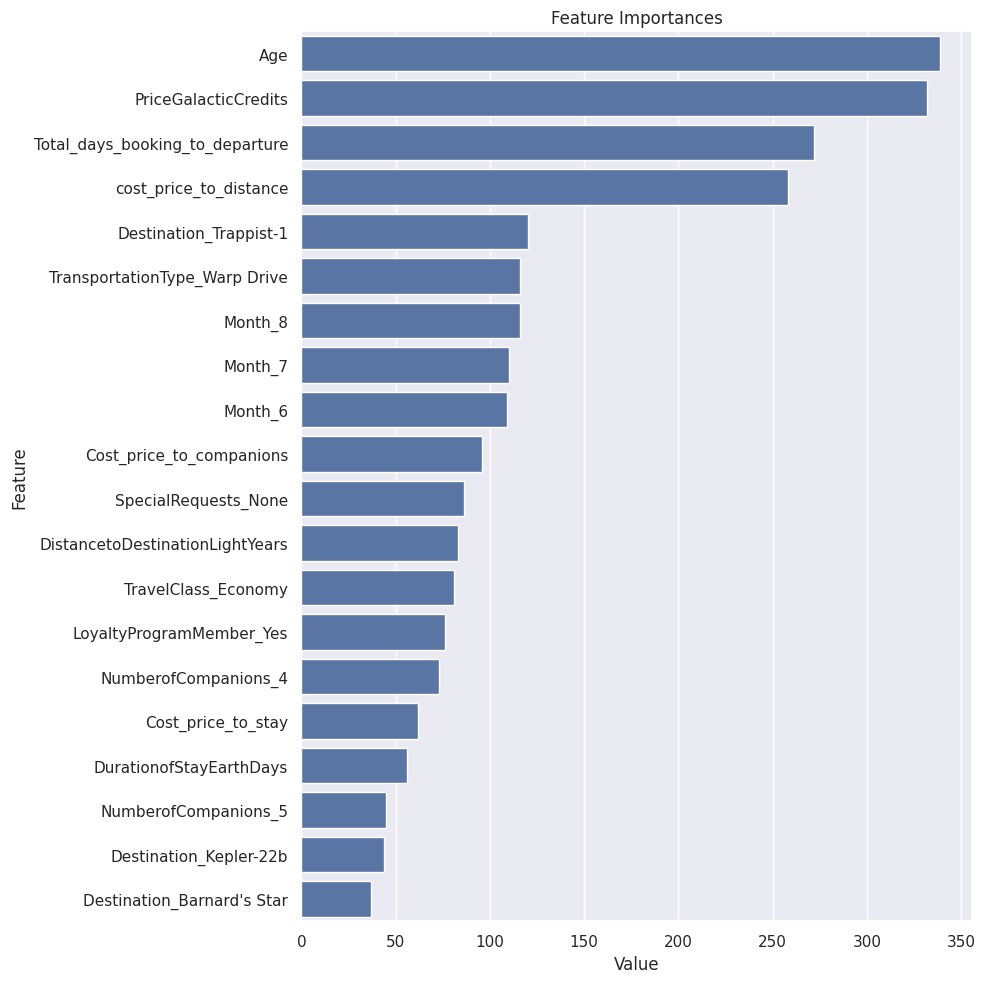

In [96]:
 ###########################################################################
def plot_importance(model, features, num=20, save=False):

    if not hasattr(model, 'feature_importances_'):
        raise AttributeError(f"The model does not have feature importances. Ensure that the model is fitted and has the attribute 'feature_importances_'.")

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})

    if num > len(features.columns):
        num = len(features.columns)

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:num])
    plt.title('Feature Importances')
    plt.tight_layout()

    if save:
        plt.savefig('importances.png')
    plt.show()

plot_importance(lightgbm_model, X_train)

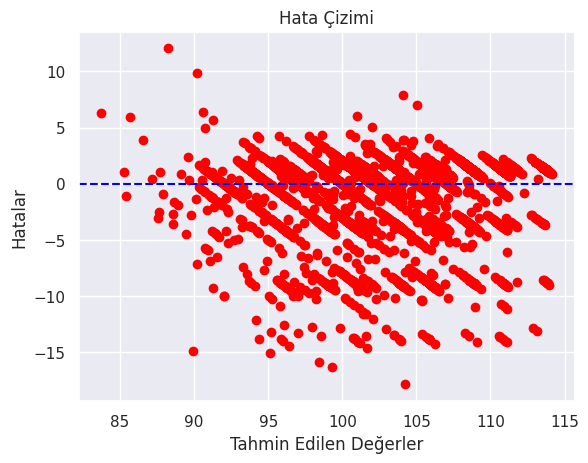

In [97]:

#################################################
# Hata Grafiği Oluşturma

hatalar = y_test - y_pred

plt.scatter(y_pred, hatalar,color="Red")
plt.xlabel('Tahmin Edilen Değerler')
plt.ylabel('Hatalar')
plt.title('Hata Çizimi')
plt.axhline(0,color="Blue",linestyle="--")
plt.show()
########